## __Dirichlet Variational Autoencoder (DirVAE)__

Source: [Dirichlet Variational Autoencoder](https://www.sciencedirect.com/science/article/abs/pii/S0031320320303174)

We will be implementing directly from the paper. Experimenting on Dirichlet VAE to access how it can perform on toy MNIST dataset, despite not quite suitable for image dataset.

In [13]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.transforms import v2
from torchinfo import summary

In [14]:
#transforming and downloading the MNIST
transform = v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32, scale=True)])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [15]:
#creating data loader
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

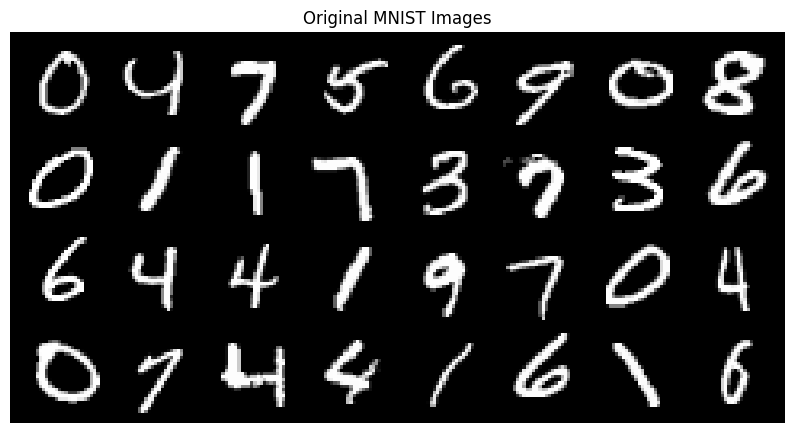

In [16]:
#function to visualize some samples off dataset
def show_images(images, title=None, nrow=8):

  grid = make_grid(images, nrow=nrow, padding=2, normalize=True)
  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(grid, (1,2,0))) #changing order of grid to (H, W, C)
  if title:
    plt.title(title)
  plt.axis('off')
  plt.show()

#getting new batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

#plotting images
show_images(images[:32], "Original MNIST Images")

### __DirVAE Architecture__

In general VAE, we have an encoder, $q_{\phi}(z |x)$ that approximates the posterior over latent variable, $z$ given input $x$, and a decoder that re-generate input $x$ from latent variable $z$.

The prior $p(z)$ is standard gaussian, and the approximate posterior, $q_{\phi}(z|x)$ is also a Gaussian with mean and variance learned from the input $x$. Afterwards, the model is trained by maximizing the Evidence Lower Bound (ELBO):

$$\begin{equation} \text{log}p(x) \ge L(x) = \mathbb{E}_{q_{\theta}(z|x)}[\text{log} p_{\theta}(x |z)] - \text{KL}([q_{\phi}(z |x) || p_{\theta}(z)]) \end{equation}$$

First term in eq(1) is recontruction loss, and the second term is KL-Divergence loss.

But in __Dirichlet Variational Autoencoder (DirVAE)__, for the prior distribution assumption on the latent variable $z$, we use Dirichlet distribution instead of Gaussian.
$z ∼ p(z) = \text{Dirichlet}(\alpha)$

In [17]:
class DirichletEncoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        self.fc1 = nn.Linear(128*4*4, latent_dim)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.flatten(1)
        #constant is added to avoid zero from softplus for Dirichlet
        alpha_hat = F.softplus(self.fc1(x)) + 1e-4
        return alpha_hat

class DirichletDecoder(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, 128*4*4)
        self.conv_trans_layers = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc1(z)
        x = x.view(-1, 128, 4, 4)
        return self.conv_trans_layers(x)

We know that, dirichlet distribution is a composition of multiple gamma random variable as PDFs of Dirichlet and Gamma distribution are as follows:

$$\text{Dirichlet}(x;α) = \frac{Γ (∑ \alpha_{k})}{Π Γ (\alpha_{k})} Π x_{k}^{\alpha_{k}-1} \qquad

\text{Gamma}(x; \alpha\beta) = \frac{\beta^{\alpha}}{Γ (\alpha)}x^{α - 1}e^{-βx}$$

So, if there are $K$ independent random variables following the Gamma distribution $X_{k} ∼ \text{Gamma}(\alpha_{k}, \beta)$ or $X ∼ \text{MultiGamma}(\alpha, β ⋅ 1_{k})$, then we have $Y ∼ Dirichlet(\alpha)$ where $Y_{k} = X_{k}/ Σ X_{i}$

Then, the KL-Divergence can be derived as following:

$$\text{KL (Q || P)} = Σ \text{log} Γ (\alpha_{k}) - Σ \text{log} Γ (\hat\alpha_{k}) + Σ (\hatα - \alpha_{k})ψ (\hat\alpha_{k})$$

for $P = \text{MultiGamma}(α, β ⋅ 1_{k})$  and
$Q = \text{MultiGamma}(\hat\alpha, β ⋅ 1_{k})$, where $\psi$ is a digamma function

So, instead of sampling from the Dirichlet distribution, we use Gamma composition method. In this, we first draw $v ∼ \text{MultiGamma}(\alpha, \beta⋅ 1_{k})$, and then normalize $v$ with its summation $∑ v_{i}$ i.e., $z_{k} = \frac{v_{k}}{\sum_{i}v_{i}}$

The objective function of our model is to optimize $\theta$ and $\phi$, and for that our loss function can be now be written as (after getting the posterior Dirichlet by gamma composition) :

$$\mathcal{L}(x)= \mathbb{E}_{q_{\phi}(z|x)}[\text{log}p_{\theta}(x|z)] - (Σ \text{log} Γ (\alpha_{k}) - Σ \text{log} Γ (\hat\alpha_{k}) + Σ (\hatα - \alpha_{k})ψ (\hat\alpha_{k}))$$

Next, for gradients to flow backwards, three methods are suggested . Inverse Gamma CDF, Weibull distribution, and Softmax Gaussian with  Laplace approximation. We are going to use _Inverse Gamma CDF_ as it is used in the paper.

__Approximation with Inverse Gamma CDF :__ If we have $X ∼ \text{Gamma}(\alpha, \beta)$ and if $F(x;\alpha, \beta)$ is CDF of random variable $X$, then the inverse CDF can be approximated as $F^{-1}(u; \alpha, \beta)$ i.e., 

$X ≈ \beta^{-1}(u α Γ (\alpha))^{\frac{1}{\alpha}}$ 

Here, $u ∼ \text{Uniform}(0,1)$ is the auxiliary variable like $\epsilon$ in __reparameterization trick__ to take over all the randomness

In [18]:
class DirichletVAE(nn.Module):
    def __init__(self, latent_dim=10):
        super().__init__()
        self.encoder = DirichletEncoder(latent_dim)
        self.decoder = DirichletDecoder(latent_dim)
        self.alpha_prior = (1 - 1/latent_dim) * torch.ones(latent_dim)
        self.latent_dim = latent_dim

    def sample_dirichlet(self, alpha, beta=1.0):
        """
        beta = 1.0 suggest in paper
        First taking randomness in U, then taking inverse gamma CDF,
        and lastly normalizing to get Dirichlet sample.
        """
        u = torch.rand_like(alpha)
        gamma_sample = (1 / beta) * (u * torch.lgamma(alpha).exp() * alpha)**(1.0 / alpha)
        dirichlet_sample = gamma_sample / gamma_sample.sum(dim=1, keepdim=True)
        return dirichlet_sample

    def kl_divergence(self, alpha_q, alpha_p):
        """
        KL divergence (Q ||P) as in the equation given above
        """
        term1 = torch.sum(torch.lgamma(alpha_p) - torch.lgamma(alpha_q), dim=1, keepdim=True)
        term2 = torch.sum((alpha_q - alpha_p) * torch.digamma(alpha_q), dim=1, keepdim=True)
        return (term1 + term2).mean()

    def forward(self, x):
        alpha_hat = self.encoder(x)
        z = self.sample_dirichlet(alpha_hat)
        x_recon = self.decoder(z)
        return x_recon, z, alpha_hat

    def loss_function(self, x, x_recon, alpha_hat):
        batch_size = x.size(0)
        alpha_p = self.alpha_prior.unsqueeze(0).expand(batch_size, -1)
        recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum') / batch_size
        kl_loss = self.kl_divergence(alpha_hat, alpha_p)
        total_loss = recon_loss + kl_loss
        return total_loss, recon_loss, kl_loss

In [19]:
# Hyperparameters
learning_rate = 1e-4
num_epochs = 20
latent_dim = 20

#Modelling
model = DirichletVAE(latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
print(summary(model, input_size=(2,1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
DirichletVAE                             [2, 1, 28, 28]            --
├─DirichletEncoder: 1-1                  [2, 20]                   --
│    └─Sequential: 2-1                   [2, 128, 4, 4]            --
│    │    └─Conv2d: 3-1                  [2, 32, 14, 14]           320
│    │    └─BatchNorm2d: 3-2             [2, 32, 14, 14]           64
│    │    └─LeakyReLU: 3-3               [2, 32, 14, 14]           --
│    │    └─Conv2d: 3-4                  [2, 64, 7, 7]             18,496
│    │    └─BatchNorm2d: 3-5             [2, 64, 7, 7]             128
│    │    └─LeakyReLU: 3-6               [2, 64, 7, 7]             --
│    │    └─Conv2d: 3-7                  [2, 128, 4, 4]            73,856
│    │    └─BatchNorm2d: 3-8             [2, 128, 4, 4]            256
│    │    └─LeakyReLU: 3-9               [2, 128, 4, 4]            --
│    └─Linear: 2-2                       [2, 20]                   40,980


In [21]:
#training loop
import time
start = time.perf_counter()
def train(epoch):

  model.train()
  accumulated_recon_loss = 0
  accumulated_kld_loss = 0
  training_loss = 0

  for batch_idx, (data, _) in enumerate(train_loader):
    optimizer.zero_grad()
    recon, z, alpha = model(data)
    total_loss, recon_loss, kld_loss = model.loss_function(data, recon, alpha)

    total_loss.backward()
    training_loss += total_loss.item()
    accumulated_recon_loss += recon_loss.item()
    accumulated_kld_loss += kld_loss.item()
    optimizer.step()

  print(f'Epoch: {epoch} Total Loss: {training_loss / len(train_loader.dataset):.2f} '
          f'Reconstruction Loss: {accumulated_recon_loss /len(train_loader.dataset):.2f} '
          f'KL-D Loss: {accumulated_kld_loss /len(train_loader.dataset):.2f}')
for epoch in range(1, num_epochs + 1):
  train(epoch)

end = time.perf_counter()
s2mps = lambda s: f"{s // 60:.0f} min {s % 60:.2f} s"
print(f"Total Training Time: {s2mps(end - start)}")

Epoch: 1 Total Loss: 2.46 Reconstruction Loss: 2.44 KL-D Loss: 0.02
Epoch: 2 Total Loss: 1.41 Reconstruction Loss: 1.33 KL-D Loss: 0.08
Epoch: 3 Total Loss: 1.16 Reconstruction Loss: 1.05 KL-D Loss: 0.11
Epoch: 4 Total Loss: 1.08 Reconstruction Loss: 0.96 KL-D Loss: 0.12
Epoch: 5 Total Loss: 1.03 Reconstruction Loss: 0.91 KL-D Loss: 0.13
Epoch: 6 Total Loss: 1.01 Reconstruction Loss: 0.88 KL-D Loss: 0.13
Epoch: 7 Total Loss: 0.99 Reconstruction Loss: 0.86 KL-D Loss: 0.13
Epoch: 8 Total Loss: 0.98 Reconstruction Loss: 0.84 KL-D Loss: 0.14
Epoch: 9 Total Loss: 0.97 Reconstruction Loss: 0.83 KL-D Loss: 0.14
Epoch: 10 Total Loss: 0.96 Reconstruction Loss: 0.82 KL-D Loss: 0.14
Epoch: 11 Total Loss: 0.95 Reconstruction Loss: 0.81 KL-D Loss: 0.14
Epoch: 12 Total Loss: 0.95 Reconstruction Loss: 0.80 KL-D Loss: 0.14
Epoch: 13 Total Loss: 0.94 Reconstruction Loss: 0.80 KL-D Loss: 0.14
Epoch: 14 Total Loss: 0.94 Reconstruction Loss: 0.79 KL-D Loss: 0.14
Epoch: 15 Total Loss: 0.93 Reconstruction L

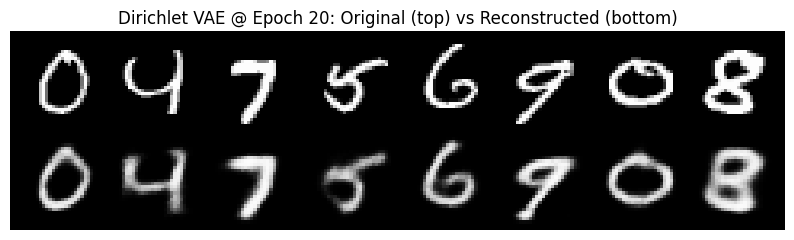

<Figure size 640x480 with 0 Axes>

In [22]:
# reconstructing some images after last epoch
model.eval()
with torch.no_grad():
  sample = images[:8]
  recon, _, _ = model(sample)

  # Show original and reconstructed images
  comparison = torch.cat([sample, recon])
  show_images(comparison, f'Dirichlet VAE @ Epoch {epoch}: Original (top) vs Reconstructed (bottom)')
  plt.savefig('img/dirichlet_vae.png')

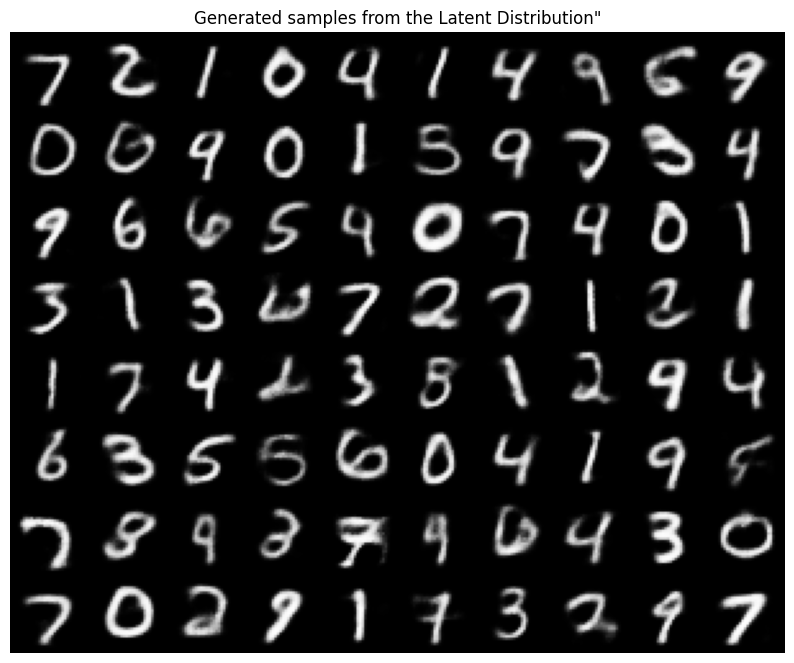

In [23]:
model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    recon, _, _ = model(data)
    show_images(recon[:80], 'Generated samples from the Latent Distribution"', nrow=10)